In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
from scipy.special import digamma, gamma, logsumexp, expit
from scipy.stats import norm, gamma, bernoulli
import torch
import torch.distributions as dist
from torch import nn
# from torchvision import datasets, transforms
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

In [7]:
%config InlineBackend.figure_format = 'retina'

# Data

In [8]:
df = pd.read_csv("../data_full.csv", index_col=0)
df.drop(df[(df.domain != "active.fi") | (df.n_session_done != 14)].index, inplace=True)
df["ts_display"] = pd.to_datetime(df["ts_display"])  # str to datetime
df["ts_reply"] = pd.to_datetime(df["ts_reply"]) 
# Convert timestamps into seconds
beginning_history = pd.Timestamp("1970-01-01", tz="UTC")
df["timestamp"] = (df["ts_reply"] - beginning_history).dt.total_seconds().values
# Copy actual item ID
df["item_id"] = df.item
for i, i_id in enumerate(df.item_id.unique()): 
    df.loc[df.item_id == i_id, 'item'] = i
df

,user,domain,condition,item,success,teacher_md,learner_md,psy_md,session,is_eval,ts_display,ts_reply,n_session_done,timestamp,item_id
49739,goldfish@active.fi,active.fi,ThresholdCondition,0,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:37.666000+00:00,2020-09-30 17:51:41.042000+00:00,14,1.601488e+09,1506
49740,goldfish@active.fi,active.fi,ThresholdCondition,1,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:42.081000+00:00,2020-09-30 17:51:43.910000+00:00,14,1.601488e+09,190
49741,goldfish@active.fi,active.fi,ThresholdCondition,2,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:44.980000+00:00,2020-09-30 17:51:46.413000+00:00,14,1.601488e+09,1000
49742,goldfish@active.fi,active.fi,ThresholdCondition,0,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:47.476000+00:00,2020-09-30 17:51:50.206000+00:00,14,1.601488e+09,1506
49743,goldfish@active.fi,active.fi,ThresholdCondition,1,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:51.245000+00:00,2020-09-30 17:51:53.477000+00:00,14,1.601488e+09,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147617,azalea@active.fi,active.fi,ThresholdCondition,103,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:21.524000+00:00,2020-10-08 05:52:31.640000+00:00,14,1.602136e+09,179
147618,azalea@active.fi,active.fi,ThresholdCondition,1349,False,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:32.658000+00:00,2020-10-08 05:52:45.959000+00:00,14,1.602136e+09,1071
147619,azalea@active.fi,active.fi,ThresholdCondition,563,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:48.143000+00:00,2020-10-08 05:52:51.527000+00:00,14,1.602136e+09,1196
147620,azalea@active.fi,active.fi,ThresholdCondition,202,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:52.543000+00:00,2020-10-08 05:52:56.460000+00:00,14,1.602136e+09,1282


In [9]:
n_u = len(df.user.unique())
n_o_by_u = np.zeros(shape=n_u, dtype=int)
for u, (user, user_df) in enumerate(df.groupby("user")):
    n_o_by_u[u] = len(user_df) - len(user_df.item.unique()) # Do not count first presentation
n_o_max = n_o_by_u.max()
n_o_min = n_o_by_u.min()
n_obs = n_o_by_u.sum()
print("number of user", n_u)
print("total number of observations (excluding first presentation)", n_obs)
print("minimum number of observation for a single user", n_o_min)
print("maximum number of observation for a single user", n_o_max)

number of user 53
total number of observations (excluding first presentation) 70618
minimum number of observation for a single user 1285
maximum number of observation for a single user 1404


In [10]:
y = np.zeros(shape=n_obs, dtype=int)
d = np.zeros(shape=n_obs, dtype=float)
w = np.zeros(shape=n_obs, dtype=int)
r = np.zeros(shape=n_obs, dtype=int)
u = np.zeros(shape=n_obs, dtype=int)

idx = 0

for i_u, (user, user_df) in enumerate(df.groupby("user")):
    
    user_df = user_df.sort_values(by="timestamp")
    seen = user_df.item.unique()
    w_u = user_df.item.values      # Words
    ts_u = user_df.timestamp.values
    counts = {word: -1 for word in seen}
    last_pres = {word: None for word in seen}
    r_u = np.zeros(len(user_df))   # Number of repetitions
    d_u = np.zeros(r_u.shape)      # Time elapsed since last repetition 
    for i, word in enumerate(w_u):
        ts = ts_u[i]
        r_u[i] = counts[word]
        if last_pres[word] is not None:
            d_u[i] =  ts - last_pres[word]
        counts[word] += 1
        last_pres[word] = ts
    
    to_keep = r_u >= 0
    y_u = user_df.success.values[to_keep]
    r_u = r_u[to_keep]
    w_u = w_u[to_keep]
    d_u = d_u[to_keep]
    
    n_ou = len(y_u)
    # assert n_o_by_u[i_u] == n_ou
    
    y[idx:idx+n_ou] = y_u
    d[idx:idx+n_ou] = d_u
    w[idx:idx+n_ou] = w_u
    r[idx:idx+n_ou] = r_u
    u[idx:idx+n_ou] = i_u
    
    idx += n_ou

data = {'n_u': len(np.unique(u)), 'n_w': len(np.unique(w)), 'n_obs': len(y),
        'u': u, 'w': w, 
        'x': d, 'r': r.astype(float),
        'y': y.astype(float)}

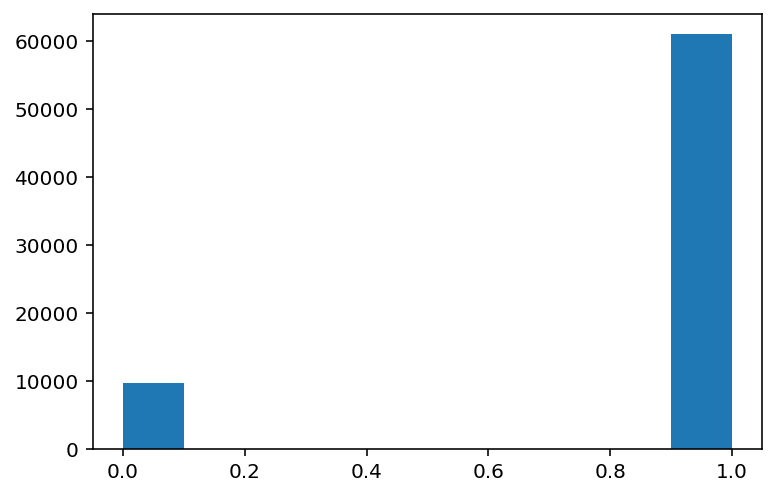

In [11]:
plt.hist(y);

# Plannar flows

In [30]:
def safe_log(z):
    return torch.log(z + 1e-7)


class PlanarFlow(nn.Module):

    def __init__(self, dim):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.tanh = nn.Tanh()

        self.reset_parameters()

    def reset_parameters(self):

        self.weight.data.uniform_(-0.01, 0.01)
        self.scale.data.uniform_(-0.01, 0.01)
        self.bias.data.uniform_(-0.01, 0.01)

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.tanh(activation)


class PlanarFlowLogDetJacobian(nn.Module):
    """A helper class to compute the determinant of the gradient of
    the planar flow transformation."""

    def __init__(self, affine):
        super().__init__()

        self.weight = affine.weight
        self.bias = affine.bias
        self.scale = affine.scale
        self.tanh = affine.tanh

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        psi = (1 - self.tanh(activation) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return safe_log(det_grad.abs())

In [31]:
class MultipleFlow(nn.Module):

    """from https://github.com/ex4sperans/variational-inference-with-normalizing-flows/blob/master/flow.py"""
    def __init__(self, dim_Z, dim_theta, flow_length):
        super().__init__()

        self.transforms_Z = nn.Sequential(*(
            PlanarFlow(dim_Z) for _ in range(flow_length)
        ))

        self.log_jacobians_Z = nn.Sequential(*(
            PlanarFlowLogDetJacobian(t) for t in self.transforms_Z
        ))
        
        self.mu_Z = nn.Parameter(torch.randn(dim_Z, ).normal_(0, 0.01))
        self.log_var_Z = nn.Parameter(torch.randn(dim_Z, ).normal_(1, 0.01))
        
        self.transforms_theta = nn.Sequential(*(
            PlanarFlow(dim_theta) for _ in range(flow_length)
        ))

        self.log_jacobians_theta = nn.Sequential(*(
            PlanarFlowLogDetJacobian(t) for t in self.transforms_theta
        ))
        
        
        self.mu_theta = nn.Parameter(torch.randn(dim_theta, ).normal_(0, 0.01))
        self.log_var_theta = nn.Parameter(torch.randn(dim_theta, ).normal_(1, 0.01))
        
        self.flow_length = flow_length

    def forward(self, shape_Z, shape_theta):
        
        std = torch.exp(0.5 * self.log_var_Z)
        eps = torch.randn(shape_Z)  # unit gaussian
        z0_Z = self.mu_Z + eps * std

        z = z0_Z
        
        ldj_Z = torch.zeros((self.flow_length, shape_Z[0], 1))

        for i in range(self.flow_length):
        
            transform, log_jacobian = self.transforms_Z[i], self.log_jacobians_Z[i]
            ldj_Z[i, :] = log_jacobian(z)
            z = transform(z)

        zk_Z = z
        
        std = torch.exp(0.5 * self.log_var_theta)
        eps = torch.randn(shape_theta)  # unit gaussian
        z0_theta = self.mu_theta + eps * std

        z = z0_theta
        
        ldj_theta = torch.zeros((self.flow_length, shape_theta[0], 1))

        for i in range(self.flow_length):
        
            transform, log_jacobian = self.transforms_theta[i], self.log_jacobians_theta[i]
            ldj_theta[i, :] = log_jacobian(z)
            z = transform(z)

        zk_theta = z

        return (z0_Z, zk_Z, ldj_Z, self.mu_Z, self.log_var_Z, 
                z0_theta, zk_theta, ldj_theta, self.mu_theta, self.log_var_theta)

In [32]:
def det_loss(x, y, r, u, w, n_u, n_w, flow):
    
    z0_Z, zk_Z, ldj_Z, mu_Z, log_var_Z, \
        z0_theta, zk_theta, ldj_theta, mu_theta, log_var_theta = flow(shape_Z=(1, (n_u+n_w)*2),
                                                                      shape_theta=(1, 3*2))
    
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0_Z = dist.Normal(mu_Z, torch.exp(0.5 * log_var_Z)).log_prob(z0_Z)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk_Z = log_qz0_Z.sum() - ldj_Z.sum()
    
    # Qz0
    log_qz0_theta = dist.Normal(mu_theta, torch.exp(0.5 * log_var_theta)).log_prob(z0_theta)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk_theta = log_qz0_theta.sum() - ldj_theta.sum()
    
    # P(x|z)
    Zu1 = zk_Z[0, :n_u]
    Zw1 = zk_Z[0, n_u:n_w+n_u]
    
    Zu2 = zk_Z[0, n_w+n_u:n_w+n_u*2]
    Zw2 = zk_Z[0, n_w+n_u*2:]
    
    Z1 = Zu1[u] + Zw1[w]
    Z2 = Zu2[u] + Zw2[w]
    
    a = torch.exp(Z1)
    b = torch.sigmoid(Z2)
    
    log_p = -a*x*(1-b)**r
    try:
        nll = -dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y).sum()
    except ValueError as e:
        log_p_numpy = np.array(log_p.data)
        print('log_p', np.min(log_p_numpy), np.max(log_p_numpy))
        raise e
    
    mu1 = zk_theta[0, 0]
    log_var_u1 = zk_theta[0, 1]
    log_var_w1 = zk_theta[0, 2]
    
    mu2 = zk_theta[0, 3]
    log_var_u2 = zk_theta[0, 4]
    log_var_w2 = zk_theta[0, 5]
    
    nll_Zu1 = -dist.Normal(mu1, torch.exp(0.5*log_var_u1)).log_prob(Zu1).sum()
    nll_Zw1 = -dist.Normal(mu1, torch.exp(0.5*log_var_w1)).log_prob(Zw1).sum()
    
    nll_Zu2 = -dist.Normal(mu2, torch.exp(0.5*log_var_u2)).log_prob(Zu2).sum()
    nll_Zw2 = -dist.Normal(mu2, torch.exp(0.5*log_var_w2)).log_prob(Zw2).sum()
    
    return log_qzk_Z + log_qzk_theta + nll + nll_Zu1 + nll_Zw1 + nll_Zu2 + nll_Zw2

In [33]:
def train_flow(x, y, r, u, w, n_u, n_w, epochs=1000):
    
    flow = MultipleFlow(dim_Z=(n_u+n_w)*2, dim_theta=3*2, flow_length=16)
    
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)
    hist_loss = np.zeros(epochs)
    
    with tqdm(total=epochs) as pbar:
        for i in range(epochs):
            # try:
            loss = det_loss(x=x, y=y,r=r, u=u, w=w, n_u=n_u, n_w=n_w, flow=flow)
            loss.backward()
            hist_loss[i] = loss.item()

            optim.step()
            optim.zero_grad()
            if i % 50 == 0:
                pbar.set_postfix({'loss': loss.item()})
#             except Exception as e:
#                 print(f"Ecounter error: {e}")
    
            pbar.update()
    
    return flow, hist_loss


# Run

In [ ]:
flow, hist_loss = train_flow(x=torch.from_numpy(data['x']), y=torch.from_numpy(data['y']), 
                             r=torch.from_numpy(data['r']), u=data['u'], w=data['w'],
                             n_u=data['n_u'], n_w=data['n_w'],
                             epochs=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
plt.plot(hist_loss)

In [ ]:
plt.plot(hist_loss[-1000:])

In [ ]:
z0_Z, zk_Z, ldj_Z, mu_Z, log_var_Z, \
    z0_theta, zk_theta, ldj_theta, mu_theta, log_var_theta = flow(shape_Z=(5000, (data['n_u']+data['n_w'])*2), 
                                                                  shape_theta=(5000, 3*2))

In [ ]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

ax = axes[0, 0]
ax.set_title(r"$\alpha$ - $U$")
ax.scatter(zk_theta.data[:, 0], zk_theta.data[:, 1], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

ax = axes[1, 0]
ax.set_title(r"$\alpha$ - $W$")
ax.scatter(zk_theta.data[:, 0], zk_theta.data[:, 2], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

ax = axes[0, 1]
ax.set_title(r"$\beta$ - $U$")
ax.scatter(zk_theta.data[:, 3], zk_theta.data[:, 4], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")

ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

ax = axes[1, 1]
ax.set_title(r"$\beta$ - $W$")
ax.scatter(zk_theta.data[:, 3], zk_theta.data[:, 5], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

# A little bit more of iterations

In [ ]:
flow, hist_loss = train_flow(x=torch.from_numpy(data['x']), y=torch.from_numpy(data['y']), 
                             r=torch.from_numpy(data['r']), u=data['u'], w=data['w'],
                             n_u=data['n_u'], n_w=data['n_w'],
                             epochs=50000)

In [ ]:
plt.plot(hist_loss)

In [ ]:
plt.plot(hist_loss[-1000:])

In [ ]:
z0_Z, zk_Z, ldj_Z, mu_Z, log_var_Z, \
    z0_theta, zk_theta, ldj_theta, mu_theta, log_var_theta = flow(shape_Z=(5000, (data['n_u']+data['n_w'])*2), 
                                                                  shape_theta=(5000, 3*2))

In [ ]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

ax = axes[0, 0]
ax.set_title(r"$\alpha$ - $U$")
ax.scatter(zk_theta.data[:, 0], zk_theta.data[:, 1], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

ax = axes[1, 0]
ax.set_title(r"$\alpha$ - $W$")
ax.scatter(zk_theta.data[:, 0], zk_theta.data[:, 2], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

ax = axes[0, 1]
ax.set_title(r"$\beta$ - $U$")
ax.scatter(zk_theta.data[:, 3], zk_theta.data[:, 4], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")

ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();

ax = axes[1, 1]
ax.set_title(r"$\beta$ - $W$")
ax.scatter(zk_theta.data[:, 3], zk_theta.data[:, 5], 
           color='C0', alpha=0.2, label=r"$\theta \sim Q(\theta)$")
ax.set_xlabel("$\mu /2$")
ax.set_ylabel("$log(\sigma^2)$")
ax.legend();